In [10]:
# ===== BLOQUE A: Carga robusta y mapeo por firma de columnas =====
import pandas as pd
from google.colab import files

uploaded = files.upload()
assert len(uploaded) >= 2, "Debes subir los dos .xlsx (investigadores y grupos)."

def detect_kind(df_cols):
    cols = set([c.upper() for c in df_cols])
    has_pr = any(c.endswith('_PR') for c in cols) or 'ID_PERSONA_PR' in cols or 'NME_GENERO_PR' in cols
    has_gr = any(c.endswith('_GR') for c in cols) or 'COD_GRUPO_GR' in cols or 'NME_GRUPO_GR' in cols
    if has_pr and not has_gr:
        return 'investigadores'
    if has_gr and not has_pr:
        return 'grupos'
    # Empate/ambigüedad: decidir por mayoría de sufijos
    pr_count = sum(1 for c in cols if c.endswith('_PR'))
    gr_count = sum(1 for c in cols if c.endswith('_GR'))
    if pr_count > gr_count:
        return 'investigadores'
    if gr_count > pr_count:
        return 'grupos'
    return 'desconocido'

# Leer todos los archivos y clasificar
candidates = {}
for fname in uploaded.keys():
    df = pd.read_excel(fname)
    kind = detect_kind(df.columns)
    candidates[kind] = (fname, df)
    print(f"Archivo '{fname}' detectado como: {kind} | shape={df.shape}")

# Validaciones
assert 'investigadores' in candidates, "No se detectó archivo de INVESTIGADORES. Revisa que lo hayas subido."
assert 'grupos' in candidates, "No se detectó archivo de GRUPOS. Revisa que lo hayas subido."

# Asignar dataframes correctos
inv_name, inv = candidates['investigadores']
grp_name, grp = candidates['grupos']

print("\n=== Asignación final ===")
print(f"- Investigadores <- {inv_name} | shape={inv.shape}")
print(f"- Grupos         <- {grp_name} | shape={grp.shape}")

# Chequeo de ANO_CONVO en ambos
for name, df in [('INVESTIGADORES', inv), ('GRUPOS', grp)]:
    s = df['ANO_CONVO'] if 'ANO_CONVO' in df.columns else None
    print(f"\n[{name}] columnas clave ejemplo:", list(df.columns[:8]))
    if s is None:
        print(f"[{name}] ¡No existe ANO_CONVO!")
        continue
    print(f"[{name}] dtype ANO_CONVO:", s.dtype)
    print(f"[{name}] primeras 8 celdas ANO_CONVO:", list(s.dropna().head(8)))
    # Rango numérico para detectar epoch
    num = pd.to_numeric(s, errors='coerce')
    if num.notna().any():
        print(f"[{name}] rango numérico ANO_CONVO:", float(num.min(skipna=True)), "→", float(num.max(skipna=True)))
    # Años por parse directo (solo diagnóstico)
    years_try = pd.to_datetime(s, errors='coerce').dt.year.dropna().unique().tolist()
    print(f"[{name}] años detectados via to_datetime:", sorted(years_try)[:10])


Saving Grupos_de_Investigaci_n_Reconocidos_2021.xlsx to Grupos_de_Investigaci_n_Reconocidos_2021.xlsx
Saving Investigadores_Reconocidos_por_convocatoria_2021.xlsx to Investigadores_Reconocidos_por_convocatoria_2021.xlsx
Archivo 'Grupos_de_Investigaci_n_Reconocidos_2021.xlsx' detectado como: grupos | shape=(30051, 21)
Archivo 'Investigadores_Reconocidos_por_convocatoria_2021.xlsx' detectado como: investigadores | shape=(77237, 30)

=== Asignación final ===
- Investigadores <- Investigadores_Reconocidos_por_convocatoria_2021.xlsx | shape=(77237, 30)
- Grupos         <- Grupos_de_Investigaci_n_Reconocidos_2021.xlsx | shape=(30051, 21)

[INVESTIGADORES] columnas clave ejemplo: ['ID_CONVOCATORIA', 'NME_CONVOCATORIA', 'ANO_CONVO', 'ID_PERSONA_PR', 'ID_AREA_CON_PR', 'NME_ESP_AREA_PR', 'NME_AREA_PR', 'NME_GRAN_AREA_PR']
[INVESTIGADORES] dtype ANO_CONVO: datetime64[ns]
[INVESTIGADORES] primeras 8 celdas ANO_CONVO: [Timestamp('2013-10-31 00:00:00'), Timestamp('2013-10-31 00:00:00'), Timestamp('2

In [11]:
# ==== BLOQUE B: Conteos por año (sin graficar) ====

import pandas as pd

# Si no existen, vuelve a leer desde los nombres detectados en el bloque A
try:
    inv, grp
except NameError:
    inv = pd.read_excel('Investigadores_Reconocidos_por_convocatoria_2021.xlsx')
    grp = pd.read_excel('Grupos_de_Investigaci_n_Reconocidos_2021.xlsx')

def counts_by_year(df, name):
    if 'ANO_CONVO' not in df.columns:
        raise ValueError(f"[{name}] no tiene columna ANO_CONVO")

    # Extraer año desde datetime64[ns] (ya vimos que ambos vienen así)
    year = pd.to_datetime(df['ANO_CONVO'], errors='coerce').dt.year

    # Resumen
    vc = (year
          .dropna()
          .astype(int)
          .value_counts()
          .sort_index())
    total = int(vc.sum())

    print(f"\n[{name}] años únicos: {sorted(year.dropna().astype(int).unique().tolist())}")
    print(f"[{name}] total registros contados por año: {total}")
    print(f"[{name}] shape original: {df.shape[0]}")
    display(vc.rename('conteo').to_frame())

    # Devolver serie por si la usamos luego
    return vc

inv_year_counts = counts_by_year(inv, "INVESTIGADORES")
grp_year_counts = counts_by_year(grp, "GRUPOS")

# Chequeo cruzado rápido (no deben ser idénticos)
same = inv_year_counts.equals(grp_year_counts.reindex(inv_year_counts.index).fillna(0).astype(int))
print("\n¿Series idénticas investigador vs grupo? ->", same)



[INVESTIGADORES] años únicos: [2013, 2014, 2015, 2017, 2019, 2021]
[INVESTIGADORES] total registros contados por año: 77237
[INVESTIGADORES] shape original: 77237


,conteo
ANO_CONVO,
2013,8016
2014,8280
2015,10050
2017,13001
2019,16796
2021,21094



[GRUPOS] años únicos: [2013, 2014, 2015, 2017, 2019, 2021]
[GRUPOS] total registros contados por año: 30051
[GRUPOS] shape original: 30051


,conteo
ANO_CONVO,
2013,4304
2014,3970
2015,4638
2017,5207
2019,5772
2021,6160



¿Series idénticas investigador vs grupo? -> False


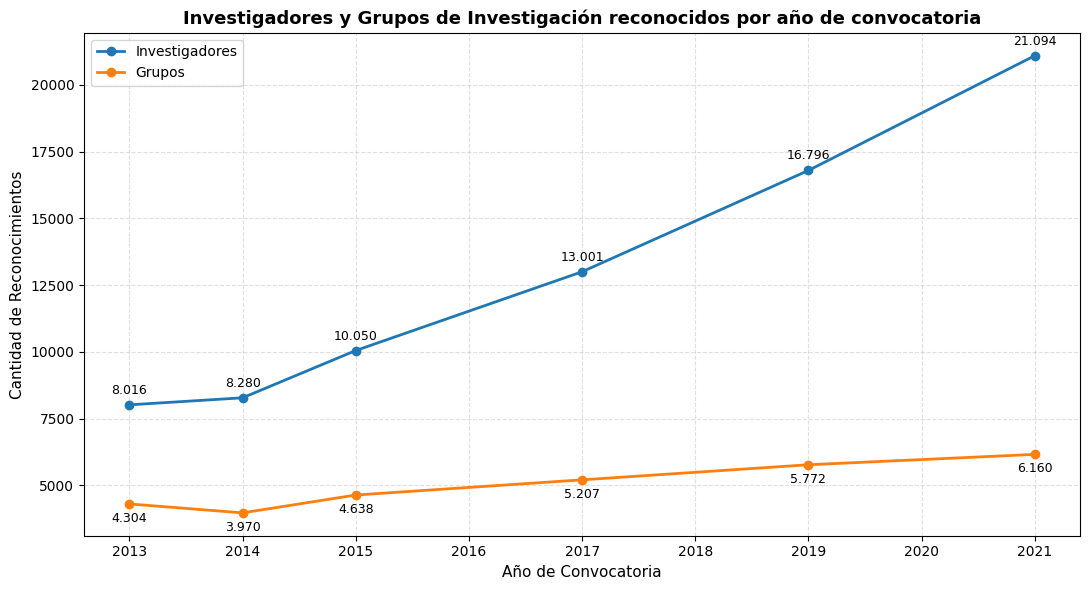

In [12]:
# ==== BLOQUE C: Gráfico final de investigadores vs grupos ====
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Fusionar series en un solo DataFrame para graficar
df_year = pd.concat([inv_year_counts.rename('Investigadores'),
                     grp_year_counts.rename('Grupos')], axis=1).fillna(0).astype(int)

# Crear figura
plt.figure(figsize=(11, 6))

# Línea de Investigadores
plt.plot(df_year.index, df_year['Investigadores'],
         marker='o', linewidth=2, color='#1f77b4', label='Investigadores')

# Línea de Grupos
plt.plot(df_year.index, df_year['Grupos'],
         marker='o', linewidth=2, color='#ff7f0e', label='Grupos')

# Etiquetas numéricas
for x, y in zip(df_year.index, df_year['Investigadores']):
    plt.text(x, y + 300, f"{y:,}".replace(",", "."), ha='center', va='bottom', fontsize=9)
for x, y in zip(df_year.index, df_year['Grupos']):
    plt.text(x, y - 300, f"{y:,}".replace(",", "."), ha='center', va='top', fontsize=9)

# Personalización del gráfico
plt.title("Investigadores y Grupos de Investigación reconocidos por año de convocatoria", fontsize=13, weight='bold')
plt.xlabel("Año de Convocatoria", fontsize=11)
plt.ylabel("Cantidad de Reconocimientos", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=10)
plt.xticks(df_year.index)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


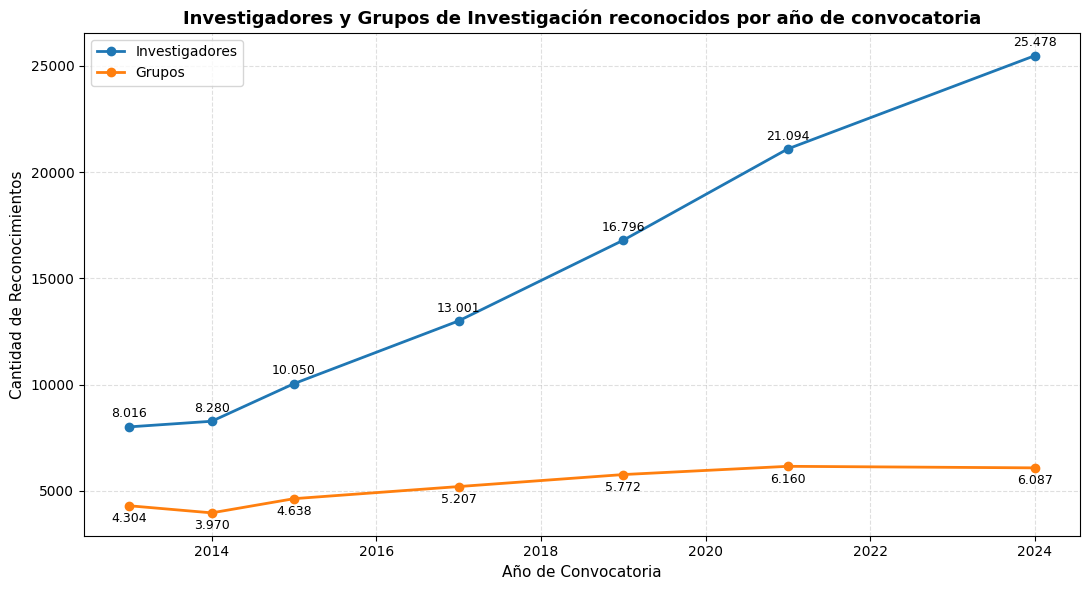

In [13]:
# ==== BLOQUE D: Añadir manualmente datos 2024 ====
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

# Partimos del DataFrame anterior (df_year)
df_year_extended = df_year.copy()

# Añadir el año 2024 manualmente
df_year_extended.loc[2024] = {'Investigadores': 25478, 'Grupos': 6087}

# Reordenar por año (por si acaso)
df_year_extended = df_year_extended.sort_index()

# Crear figura
plt.figure(figsize=(11, 6))

# Línea de Investigadores
plt.plot(df_year_extended.index, df_year_extended['Investigadores'],
         marker='o', linewidth=2, color='#1f77b4', label='Investigadores')

# Línea de Grupos
plt.plot(df_year_extended.index, df_year_extended['Grupos'],
         marker='o', linewidth=2, color='#ff7f0e', label='Grupos')

# Etiquetas numéricas
for x, y in zip(df_year_extended.index, df_year_extended['Investigadores']):
    plt.text(x, y + 300, f"{y:,}".replace(",", "."), ha='center', va='bottom', fontsize=9)
for x, y in zip(df_year_extended.index, df_year_extended['Grupos']):
    plt.text(x, y - 300, f"{y:,}".replace(",", "."), ha='center', va='top', fontsize=9)

# Personalización del gráfico
plt.title("Investigadores y Grupos de Investigación reconocidos por año de convocatoria", fontsize=13, weight='bold')
plt.xlabel("Año de Convocatoria", fontsize=11)
plt.ylabel("Cantidad de Reconocimientos", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=10)
plt.xticks(df_year_extended.index)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()
